In [1]:
#导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from sklearnex import patch_sklearn
patch_sklearn()

# tensorflow==1.9.0

Using TensorFlow backend.
g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
g:\dev\.anaconda\Miniconda\en

In [2]:
# 创建映射字典
label_number = {"装": 1, "卸": -1}

# 定义一个函数，用于将Category列的文本转换为对应数值
# def label_to_number(row):
#     v = row["state"]
#     if v not in label_number:
#         return 0
#     return label_number[v]


# def number_to_label(row):
#     v = row["state"].strip()
#     display(v)
#     if v == 1:
#         return "装"
#     elif v == -1:
#         return "卸"
#     else:
#         return "-"


dfstate = pd.read_csv("./data/states.txt")
dfstate["start"] = dfstate.apply(
    lambda row: row["date"] + " " + row["start_time"], axis=1
)
dfstate["end"] = dfstate.apply(lambda row: row["date"] + " " + row["end_time"], axis=1)
dfstate["label"] = dfstate.pop("state").str.strip()
# 转为时间类型
dfstate[["start", "end"]] = dfstate[["start", "end"]].apply(pd.to_datetime)
# dfstate["statev"] = dfstate.apply(label_to_number, axis=1)
# dfstate['label'] = dfstate.apply(number_to_label,axis=1)
dfstate.to_csv("./data/states.csv")
dfstate.head(), dfstate.shape

(         date start_time  end_time               start                 end  \
 0  2023-12-17   10:44:49  10:48:59 2023-12-17 10:44:49 2023-12-17 10:48:59   
 1  2023-12-17   11:29:45  11:31:55 2023-12-17 11:29:45 2023-12-17 11:31:55   
 2  2023-12-17   12:23:56  12:29:44 2023-12-17 12:23:56 2023-12-17 12:29:44   
 3  2023-12-17   12:55:08  12:56:28 2023-12-17 12:55:08 2023-12-17 12:56:28   
 4  2023-12-17   13:45:02  13:45:42 2023-12-17 13:45:02 2023-12-17 13:45:42   
 
   label  
 0     装  
 1     卸  
 2     装  
 3     卸  
 4     装  ,
 (56, 6))

In [3]:
# 定义读取，处理数据函数
def fix_data(inputDF: pd.DataFrame) -> pd.DataFrame:
    # 创建一个新的空列用于存储结果

    inputDF.insert(0, "label", "-")

    # 对df1中的每一行遍历，并查找df2中符合条件的记录
    for index, row in inputDF.iterrows():
        condition = (dfstate["start"] <= row["时间"]) & (row["时间"] <= dfstate["end"])
        match = dfstate[condition]

        if not match.empty:
            # 如果找到了匹配项，则将df2的'state'赋值给df1的新列
            inputDF.at[index, "label"] = match["label"].values[0]
        else:
            # 如果没有找到匹配项，则保持原样（这里已经初始化为-）
            pass

    # inputDF.insert(1,'state',0)
    # inputDF["state"] = inputDF["label"].astype("category").cat.codes
    return inputDF


def read_data(file_path: str) -> pd.DataFrame:
    return fix_data(
        pd.read_excel(file_path, engine="openpyxl", parse_dates=["时间", "轨迹时间"])
    )


# 读取数据
df1 = read_data("./data/data_17.xlsx")
df21 = read_data("./data/data_21.xlsx")
df22 = read_data("./data/data_22.xlsx")
df23 = read_data("./data/data_23.xlsx")

# df1=pd.read_csv('data.csv')

# df1=df1.iloc[:,2:]
# df1.tail(),'rows',len(df1)

In [20]:
# df1.info() 
# display(df1.shape,df21.shape,df22.shape,df23.shape)
# len(df1.query('state != 0')),len(df21.query('state != 0')),len(df22.query('state != 0')),len(df23.query('state != 0'))
# df1.head()
# display( df1.query('state != 0'),len(df21.query('state != 0')),len(df22.query('state != 0')),len(df23.query('state != 0')))
display(df1.head())
display(df1.query('label != "-"'))

,label,时间,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,...,su_x_diff,su_y_diff,su_z_diff,轨迹时间,速度,估计重量,原始重量加速度,稳定重量加速度,原始重量加速度_二阶,稳定重量加速度_二阶
0,-,2023-12-17 09:39:23,-4063.0,2020.0,-4375.0,33161.0,13662.0,326.0,76328.0,1867.0,...,0.0,0.0,0.0,2023-12-17 09:39:28,-8.881784e-16,0.0,0.0,0.0,0.0,0.0
1,-,2023-12-17 09:39:26,-4175.0,2020.0,-4364.0,33160.0,13636.0,327.0,76355.0,1867.0,...,0.0,0.0,0.0,2023-12-17 09:39:28,-8.881784e-16,0.0,0.0,0.0,0.0,0.0
2,-,2023-12-17 09:39:30,-4575.0,2020.0,-4486.0,33171.0,13649.0,312.0,76342.0,1867.0,...,0.0,5.0,5.0,2023-12-17 09:39:38,-8.881784e-16,0.0,0.0,0.0,0.0,0.0
3,-,2023-12-17 09:39:32,-4330.0,2020.0,-4397.0,33163.0,13649.0,314.0,76342.0,1867.0,...,0.0,6.0,6.0,2023-12-17 09:39:38,-8.881784e-16,0.0,0.0,0.0,0.0,0.0
4,-,2023-12-17 09:39:35,-4442.0,2020.0,-4475.0,33170.0,13648.0,314.0,76343.0,1873.0,...,6.0,-6.0,-11.0,2023-12-17 09:39:38,-8.881784e-16,0.0,0.0,0.0,0.0,0.0


,label,时间,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,...,su_x_diff,su_y_diff,su_z_diff,轨迹时间,速度,估计重量,原始重量加速度,稳定重量加速度,原始重量加速度_二阶,稳定重量加速度_二阶
1251,装,2023-12-17 10:44:51,2917.0,0.0,2917.0,32506.0,12584.0,-3878.0,76807.0,3032.0,...,0.0,0.0,0.0,2023-12-17 10:45:00,-8.881784e-16,0.0,108.825000,0.000000,0.439861,0.000000
1252,装,2023-12-17 10:44:54,3006.0,0.0,4832.0,32334.0,12565.0,-3495.0,76933.0,3032.0,...,0.0,-226.0,165.0,2023-12-17 10:45:00,-8.881784e-16,0.0,48.216667,0.000000,-0.574931,0.000000
1253,装,2023-12-17 10:44:56,-8071.0,0.0,-5433.0,33256.0,12539.0,-4495.0,76521.0,3098.0,...,66.0,121.0,-242.0,2023-12-17 10:45:00,-8.881784e-16,0.0,-84.608333,0.000000,-2.001667,0.000000
1254,装,2023-12-17 10:44:59,-10109.0,0.0,-8060.0,33492.0,12764.0,-3675.0,76653.0,2949.0,...,-149.0,-1093.0,940.0,2023-12-17 10:45:00,-8.881784e-16,0.0,4.358333,0.000000,-0.379653,0.000000
1255,装,2023-12-17 10:45:03,-25818.0,0.0,-23258.0,34857.0,13436.0,-4805.0,75648.0,2433.0,...,-516.0,-176.0,483.0,2023-12-17 10:45:10,-8.881784e-16,0.0,-189.916667,0.000000,-2.518194,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8166,卸,2023-12-17 16:57:46,36340.0,36940.0,37564.0,29394.0,13073.0,-118.0,76892.0,2883.0,...,11.0,17.0,-55.0,2023-12-17 16:57:51,-8.881784e-16,36040.0,-5.375000,-1.583333,-0.647083,-0.871181
8167,卸,2023-12-17 16:57:50,38544.0,36940.0,39446.0,29225.0,13225.0,-1.0,76762.0,2889.0,...,6.0,49.0,-16.0,2023-12-17 16:57:51,-8.881784e-16,36040.0,12.800000,-1.541667,-0.510347,-0.870486
8168,卸,2023-12-17 16:57:53,38511.0,36940.0,38578.0,29303.0,13286.0,-95.0,76702.0,2894.0,...,5.0,16.0,-11.0,2023-12-17 16:58:02,-8.881784e-16,36040.0,10.208333,-1.541667,-0.548125,-0.870486
8169,卸,2023-12-17 16:57:56,36073.0,36940.0,36930.0,29451.0,13083.0,-245.0,76894.0,2889.0,...,-5.0,11.0,-17.0,2023-12-17 16:58:02,-8.881784e-16,36040.0,-9.091667,-1.541667,-0.672708,-0.870486


g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


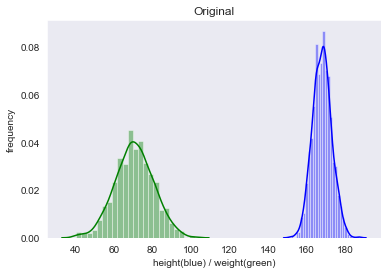

g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


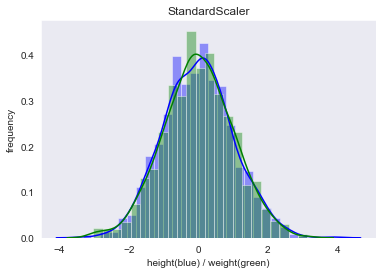

g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


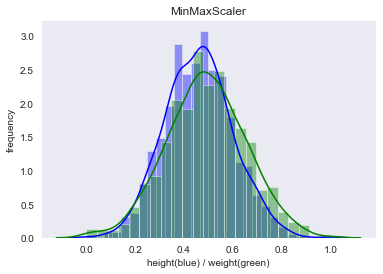

g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


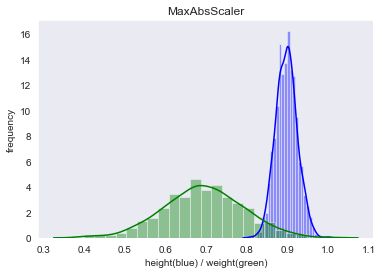

g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


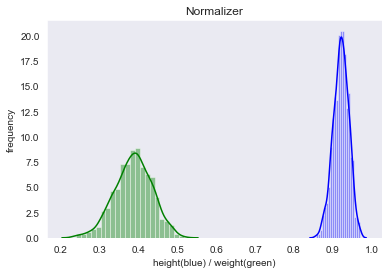

g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


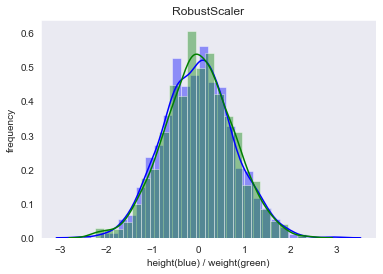

In [18]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn import preprocessing

# def plot(data, title):
#     sns.set_style('dark')
#     f, ax = plt.subplots()
#     ax.set(ylabel='frequency')
#     ax.set(xlabel='height(blue) / weight(green)')
#     ax.set(title=title)
#     sns.distplot(data[:, 0:1], color='blue')
#     sns.distplot(data[:, 1:2], color='green')
#     plt.savefig(title + '.png')
#     plt.show()

# np.random.seed(42)
# height = np.random.normal(loc=168, scale=5, size=1000).reshape(-1, 1)
# weight = np.random.normal(loc=70, scale=10, size=1000).reshape(-1, 1)

# original_data = np.concatenate((height, weight), axis=1)
# plot(original_data, 'Original')

# standard_scaler_data = preprocessing.StandardScaler().fit_transform(original_data)
# plot(standard_scaler_data, 'StandardScaler')

# min_max_scaler_data = preprocessing.MinMaxScaler().fit_transform(original_data)
# plot(min_max_scaler_data, 'MinMaxScaler')

# max_abs_scaler_data = preprocessing.MaxAbsScaler().fit_transform(original_data)
# plot(max_abs_scaler_data, 'MaxAbsScaler')

# normalizer_data = preprocessing.Normalizer().fit_transform(original_data)
# plot(normalizer_data, 'Normalizer')

# robust_scaler_data = preprocessing.RobustScaler().fit_transform(original_data)
# plot(robust_scaler_data, 'RobustScaler')

In [32]:
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler



number_types = [np.number]
label_types = ["object"]
time_types = ["datetime64[ns]"]
numeric_cols = df1.select_dtypes(include=number_types).columns.tolist()
label_cols = df1.select_dtypes(include=label_types).columns.tolist()
time_cols = df1.select_dtypes(include=time_types).columns.tolist()
# display(label_cols,time_cols,numeric_cols)

# 使用 StandardScaler 或者 MinMaxScaler 进行标准化处理。
# 创建标准化器对象
scaler = MinMaxScaler()

# （label）标准化
le = LabelEncoder()
le.fit(["装", "卸",'-'])

def normalize(inpudf: pd.DataFrame) -> pd.DataFrame:
    """对df进行标准化处理"""
    inpudf=inpudf.copy()
    # 数值型数据标准化： 使用StandardScaler或者MinMaxScaler进行标准化处理。
    scaler.fit(inpudf[numeric_cols])
    inpudf[numeric_cols] = scaler.fit_transform(inpudf[numeric_cols])

    # 类别数据（label）标准化： 类别数据通常不做标准化，而是进行编码，比如One-Hot编码或者Label Encoding。
    # for col in label_cols:
    #     inpudf[col] = le.fit_transform(inpudf[col])
    inpudf[label_cols] = le.fit_transform(inpudf[label_cols])
    # 时间数据标准化： 时间数据通常不进行标准化，而是转换成可以比较的形式，如Unix时间戳或时间段差。
    # 将所有时间列转换为Unix时间戳（单位为秒）
    for col in time_cols:
        inpudf[col] = (
            inpudf[col].astype(np.int64) / 1e9
        )  # 默认pandas的datetime64[ns]转换为Unix时间戳（秒）

    return inpudf


# 反标准化


def denormalize(inpudf: pd.DataFrame) -> pd.DataFrame:
    """对df中的数值列进行反标准化处理"""

    # 数值型数据标准化-
    inpudf[numeric_cols] = scaler.inverse_transform(inpudf[numeric_cols])

    # 类别数据（label）标准化-
    for col in label_cols:
        inpudf[col] = le.inverse_transform(inpudf[col])

    # 时间数据标准化-
    for col in time_cols:
        inpudf[col] = pd.to_datetime(
            inpudf[col] * 1e9
        )  # 默认pandas的datetime64[ns]转换为Unix时间戳（秒）

    return inpudf
df0 = normalize(df1)

df1 = denormalize(df0)
display(df1.head())
display(df0.head())

g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,label,时间,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,...,su_x_diff,su_y_diff,su_z_diff,轨迹时间,速度,估计重量,原始重量加速度,稳定重量加速度,原始重量加速度_二阶,稳定重量加速度_二阶
0,-,2023-12-17 09:39:23,-4063.0,2020.0,-4375.0,33161.0,13662.0,326.0,76328.0,1867.0,...,0.0,0.0,0.0,2023-12-17 09:39:28,-8.881784e-16,0.0,0.0,0.0,0.0,0.0
1,-,2023-12-17 09:39:26,-4175.0,2020.0,-4364.0,33160.0,13636.0,327.0,76355.0,1867.0,...,0.0,0.0,0.0,2023-12-17 09:39:28,-8.881784e-16,0.0,0.0,0.0,0.0,0.0
2,-,2023-12-17 09:39:30,-4575.0,2020.0,-4486.0,33171.0,13649.0,312.0,76342.0,1867.0,...,0.0,5.0,5.0,2023-12-17 09:39:38,-8.881784e-16,0.0,0.0,0.0,0.0,0.0
3,-,2023-12-17 09:39:32,-4330.0,2020.0,-4397.0,33163.0,13649.0,314.0,76342.0,1867.0,...,0.0,6.0,6.0,2023-12-17 09:39:38,-8.881784e-16,0.0,0.0,0.0,0.0,0.0
4,-,2023-12-17 09:39:35,-4442.0,2020.0,-4475.0,33170.0,13648.0,314.0,76343.0,1873.0,...,6.0,-6.0,-11.0,2023-12-17 09:39:38,-8.881784e-16,0.0,0.0,0.0,0.0,0.0


,label,时间,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,...,su_x_diff,su_y_diff,su_z_diff,轨迹时间,速度,估计重量,原始重量加速度,稳定重量加速度,原始重量加速度_二阶,稳定重量加速度_二阶
0,-,2023-12-17 09:39:23,-4063.0,2020.0,-4375.0,33161.0,13662.0,326.0,76328.0,1867.0,...,0.0,0.0,0.0,2023-12-17 09:39:28,-8.881784e-16,0.0,0.0,0.0,0.0,0.0
1,-,2023-12-17 09:39:26,-4175.0,2020.0,-4364.0,33160.0,13636.0,327.0,76355.0,1867.0,...,0.0,0.0,0.0,2023-12-17 09:39:28,-8.881784e-16,0.0,0.0,0.0,0.0,0.0
2,-,2023-12-17 09:39:30,-4575.0,2020.0,-4486.0,33171.0,13649.0,312.0,76342.0,1867.0,...,0.0,5.0,5.0,2023-12-17 09:39:38,-8.881784e-16,0.0,0.0,0.0,0.0,0.0
3,-,2023-12-17 09:39:32,-4330.0,2020.0,-4397.0,33163.0,13649.0,314.0,76342.0,1867.0,...,0.0,6.0,6.0,2023-12-17 09:39:38,-8.881784e-16,0.0,0.0,0.0,0.0,0.0
4,-,2023-12-17 09:39:35,-4442.0,2020.0,-4475.0,33170.0,13648.0,314.0,76343.0,1873.0,...,6.0,-6.0,-11.0,2023-12-17 09:39:38,-8.881784e-16,0.0,0.0,0.0,0.0,0.0


g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,label,时间,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,...,su_x_diff,su_y_diff,su_z_diff,轨迹时间,速度,估计重量,原始重量加速度,稳定重量加速度,原始重量加速度_二阶,稳定重量加速度_二阶
0,-,2023-12-17 09:39:23,-4063.0,2020.0,-4375.0,33161.0,13662.0,326.0,76328.0,1867.0,...,-1.387779e-17,0.0,0.0,2023-12-17 09:39:28,-8.881784e-16,0.0,0.0,0.0,0.0,-1.925930e-34
1,-,2023-12-17 09:39:26,-4175.0,2020.0,-4364.0,33160.0,13636.0,327.0,76355.0,1867.0,...,-1.387779e-17,0.0,0.0,2023-12-17 09:39:28,-8.881784e-16,0.0,0.0,0.0,0.0,-1.925930e-34
2,-,2023-12-17 09:39:30,-4575.0,2020.0,-4486.0,33171.0,13649.0,312.0,76342.0,1867.0,...,-1.387779e-17,5.0,5.0,2023-12-17 09:39:38,-8.881784e-16,0.0,0.0,0.0,0.0,-1.925930e-34
3,-,2023-12-17 09:39:32,-4330.0,2020.0,-4397.0,33163.0,13649.0,314.0,76342.0,1867.0,...,-1.387779e-17,6.0,6.0,2023-12-17 09:39:38,-8.881784e-16,0.0,0.0,0.0,0.0,-1.925930e-34
4,-,2023-12-17 09:39:35,-4442.0,2020.0,-4475.0,33170.0,13648.0,314.0,76343.0,1873.0,...,6.000000e+00,-6.0,-11.0,2023-12-17 09:39:38,-8.881784e-16,0.0,0.0,0.0,0.0,-1.925930e-34


,label,时间,原始重量,稳定重量,轴重,su_ad,wpu_x,wpu_y,wpu_z,su_x,...,su_x_diff,su_y_diff,su_z_diff,轨迹时间,速度,估计重量,原始重量加速度,稳定重量加速度,原始重量加速度_二阶,稳定重量加速度_二阶
0,-,2023-12-17 09:39:23,-4063.0,2020.0,-4375.0,33161.0,13662.0,326.0,76328.0,1867.0,...,-1.387779e-17,0.0,0.0,2023-12-17 09:39:28,-8.881784e-16,0.0,0.0,0.0,0.0,-1.925930e-34
1,-,2023-12-17 09:39:26,-4175.0,2020.0,-4364.0,33160.0,13636.0,327.0,76355.0,1867.0,...,-1.387779e-17,0.0,0.0,2023-12-17 09:39:28,-8.881784e-16,0.0,0.0,0.0,0.0,-1.925930e-34
2,-,2023-12-17 09:39:30,-4575.0,2020.0,-4486.0,33171.0,13649.0,312.0,76342.0,1867.0,...,-1.387779e-17,5.0,5.0,2023-12-17 09:39:38,-8.881784e-16,0.0,0.0,0.0,0.0,-1.925930e-34
3,-,2023-12-17 09:39:32,-4330.0,2020.0,-4397.0,33163.0,13649.0,314.0,76342.0,1867.0,...,-1.387779e-17,6.0,6.0,2023-12-17 09:39:38,-8.881784e-16,0.0,0.0,0.0,0.0,-1.925930e-34
4,-,2023-12-17 09:39:35,-4442.0,2020.0,-4475.0,33170.0,13648.0,314.0,76343.0,1873.0,...,6.000000e+00,-6.0,-11.0,2023-12-17 09:39:38,-8.881784e-16,0.0,0.0,0.0,0.0,-1.925930e-34


In [ ]:
#进行数据归一化
# from sklearn import preprocessing

# # 初始化 MinMaxScaler 对象
# min_max_scaler = preprocessing.MinMaxScaler()

# # df0=min_max_scaler.fit_transform(df1)
# # df = pd.DataFrame(df0, columns=df1.columns)
# # input_size=len(df.iloc[1,:])


# # 假设我们有一个DataFrame df，并且希望对其中的所有数值列进行标准化
# # 先提取出所有数值列
# numeric_features = df1.select_dtypes(include=[np.number]).columns.tolist()

# # 使用 fit() 方法计算最小值和最大值（训练集上）
# # min_max_scaler.fit(df1[numeric_features])
# df0=min_max_scaler.fit_transform(df1[numeric_features])
# # 使用 transform() 方法对数据进行标准化
# inpudf = pd.DataFrame(df0, columns=numeric_features, index=df1.index)
# input_size=len(inpudf.iloc[1,:])
# display(df1.head())
# display(inpudf.head())
# display(input_size,inpudf.shape)

In [8]:
#设置LSTM的时间窗等参数
window=5
lstm_units = 32
dropout = 0.01
epoch=60

#构建lstm输入
stock=df1
seq_len=window
amount_of_features = len(stock.columns)#有几列
data = stock.values #pd.DataFrame(stock) 表格转化为矩阵
sequence_length = seq_len + 1#序列长度
result = []
for index in range(len(data) - sequence_length):#循环数据长度-sequence_length次
    result.append(data[index: index + sequence_length])#第i行到i+sequence_length
result = np.array(result)#得到样本，样本形式为6天*3特征
row = round(0.9 * result.shape[0])#划分训练集测试集
train = result[:int(row), :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[int(row):, :-1]
y_test = result[int(row):, -1][:,-1]
#reshape成 6天*3特征
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

df1.values[3:5]

(14872, 5, 26) (14872,) (1652, 5, 26) (1652,)


array([[0.23125589, 0.05433759, 0.24033317, 0.75967054, 0.44792469,
        0.44668515, 0.59812322, 0.65849118, 0.48895758, 0.97351846,
        0.51213147, 0.61741601, 0.48177059, 0.51822826, 0.49747007,
        0.46678784, 0.51659466, 0.54515005, 0.56300863, 0.53552554,
        0.        , 0.        , 0.5516445 , 0.61741601, 0.59209949,
        0.5       ],
       [0.23060041, 0.05433759, 0.23981796, 0.76018532, 0.4478819 ,
        0.44668515, 0.59816855, 0.65873401, 0.4886888 , 0.97326091,
        0.51002344, 0.61741601, 0.48072101, 0.51927787, 0.49741997,
        0.46670522, 0.51664549, 0.54535102, 0.56241677, 0.53528787,
        0.        , 0.        , 0.5516445 , 0.61741601, 0.59209949,
        0.5       ]])

In [9]:
#建立LSTM模型 训练
inputs=Input(shape=(window, input_size))
model=Conv1D(filters = lstm_units, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
model=MaxPooling1D(pool_size = window)(model)#池化层
model=Dropout(dropout)(model)#droupout层
model=Bidirectional(LSTM(lstm_units, activation='tanh'), name='bilstm')(model)#双向LSTM层
attention=Dense(lstm_units*2, activation='sigmoid', name='attention_vec')(model)#求解Attention权重
model=Multiply()([model, attention])#attention与LSTM对应数值相乘
outputs = Dense(1, activation='tanh')(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()#展示模型结构

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 26)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 32)             864       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
bilstm (Bidirectional)       (None, 64)                16640     
_________________________________________________________________
attention_vec (Dense)        (None, 64)                4160   

In [10]:
history=model.fit(X_train, y_train, nb_epoch = epoch, batch_size = 256,shuffle=False,validation_data=(X_test, y_test)) #训练模型epoch次

g:\dev\.anaconda\Miniconda\envs\py36_tf19\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 14872 samples, validate on 1652 samples
Epoch 1/60
14872/14872 [==============================] - 0s - loss: 0.0319 - acc: 0.0027 - val_loss: 2.5907e-04 - val_acc: 0.0000e+00
Epoch 2/60
14872/14872 [==============================] - 0s - loss: 0.0059 - acc: 0.0038 - val_loss: 2.4717e-06 - val_acc: 0.0000e+00
Epoch 3/60
14872/14872 [==============================] - 0s - loss: 0.0059 - acc: 0.0035 - val_loss: 4.6830e-07 - val_acc: 0.0000e+00
Epoch 4/60
14872/14872 [==============================] - 0s - loss: 0.0059 - acc: 0.0038 - val_loss: 4.9022e-07 - val_acc: 0.0000e+00
Epoch 5/60
14872/14872 [==============================] - 0s - loss: 0.0059 - acc: 0.0038 - val_loss: 2.1245e-07 - val_acc: 0.0000e+00
Epoch 6/60
14872/14872 [==============================] - 0s - loss: 0.0058 - acc: 0.0046 - val_loss: 7.2097e-08 - val_acc: 0.0000e+00
Epoch 7/60
14872/14872 [==============================] - 0s - loss: 0.0058 - acc: 0.0048 - val_loss: 2.4676e-07 - val_acc: 0.0000e+00
Epoch 

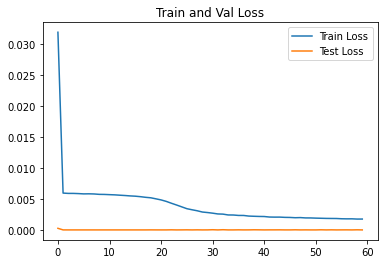

In [11]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

Text(0.5, 1.0, 'Train Data')

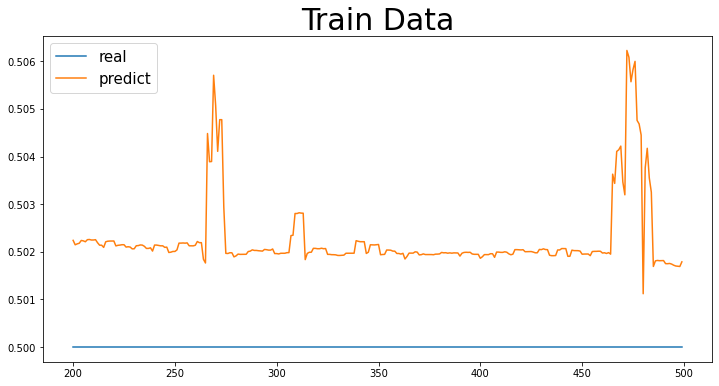

In [12]:
#在训练集上的拟合结果
y_train_predict=model.predict(X_train)
y_train_predict=y_train_predict[:,0]
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题

Text(0.5, 1.0, 'Test Data')

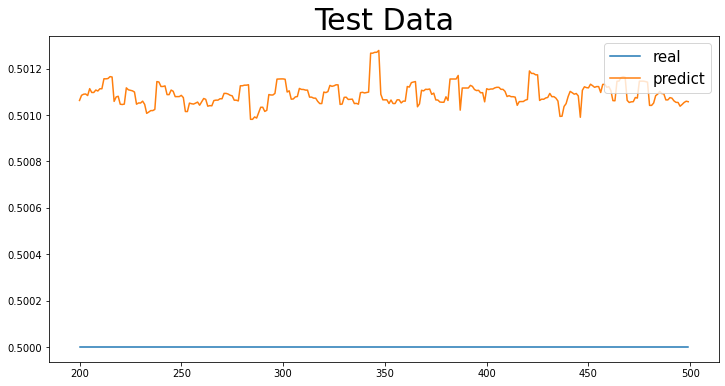

In [13]:
#在测试集上的预测
y_test_predict=model.predict(X_test)
y_test_predict=y_test_predict[:,0]
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题

In [14]:
#输出结果
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result
print('训练集上的MAE/MSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_train_predict, y_train))
print(mean_squared_error(y_train_predict, y_train) )
print(mape(y_train_predict, y_train) )
print(up_down_accuracy(y_train_predict,y_train))
print('测试集上的MAE/MSE/MAPE/涨跌准确率')
print(mean_absolute_error(y_test_predict, y_test))
print(mean_squared_error(y_test_predict, y_test) )
print(mape(y_test_predict,  y_test) )
print(up_down_accuracy(y_test_predict,y_test))

训练集上的MAE/MSE/MAPE/涨跌准确率
0.011375044148787577
0.0012382167714091717
2.665366011134947
0.11949431779974447
测试集上的MAE/MSE/MAPE/涨跌准确率
0.00108934422959427
1.1893327229212223e-06
0.21739415172113158
0.12780133252574197
